In [1]:
import numpy as np
import pandas as pd
import pickle
import collections
from matplotlib import pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
import folium
from folium.plugins import Fullscreen, HeatMap, BeautifyIcon
from folium.features import DivIcon
import math
from sklearn.metrics import ndcg_score

%matplotlib inline

In [2]:
poi_path = 'data/melb_average.csv'
traj_path = 'data/traj-Melb.csv'

In [3]:
def prepare_data(poi_path, traj_path):
    coordinates = []
    user_traj_dict = collections.defaultdict(list)
    
    poi_df = pd.read_csv(poi_path)
    traj_df = pd.read_csv(traj_path)
    
    for i in range(traj_df.shape[0]):
        user_traj_dict[traj_df.loc[i, 'trajID']].append(traj_df.loc[i, 'poiID'])
        p = traj_df.loc[i, 'poiID']
        coordinates.append([poi_df.loc[p, 'poiLat'], poi_df.loc[p, 'poiLon']])
    
    return coordinates, user_traj_dict, poi_df, traj_df

In [4]:
coordinates, user_traj_dict, poi_df, traj_df = prepare_data(poi_path, traj_path)

In [5]:
poi_size = poi_df.shape[0]

In [6]:
durations = np.zeros((poi_size))
dur_count = np.zeros((poi_size))

In [7]:
import datetime

for i in range(traj_df.shape[0]):
    dur = traj_df.loc[i, 'endTime'] - traj_df.loc[i, 'startTime']    
    p = traj_df.loc[i, 'poiID']
    durations[p] += dur
    if dur != 0:
        dur_count[p] += 1

In [8]:
durations /= 60
durations = np.nan_to_num(durations / dur_count)
# durations

<ipython-input-8-7f998bb4a86b>:2: RuntimeWarning: invalid value encountered in true_divide
  durations = np.nan_to_num(durations / dur_count)


In [9]:
def plot_heatmap(points):
    heatmap = folium.Map(
        location=[-37.815098, 144.959182],
        zoom_start=13
    )
    HeatMap(points, radius=25).add_to(heatmap)
    Fullscreen().add_to(heatmap)
    return heatmap

In [10]:
fig = plot_heatmap(coordinates)
fig

In [11]:
def plot_points(poi_df):
    poimap = folium.Map(
        location=[-37.815098, 144.959182],
        zoom_start=13
    )
    for p in range(poi_df.shape[0]):
        folium.Circle(
            radius=50,
            location = [poi_df.loc[p, 'poiLat'], poi_df.loc[p, 'poiLon']],
            color='red',
            fill=True,
            fill_color = 'red',
            fill_opacity = 1,
            popup = p
        ).add_to(poimap)

        folium.map.Marker(
        [poi_df.loc[p, 'poiLat'], poi_df.loc[p, 'poiLon']],
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="font-size: 10pt">%s</div>' % p,
            )
        ).add_to(poimap)
    Fullscreen().add_to(poimap)
    return poimap

In [12]:
poimap = plot_points(poi_df)
poimap

In [13]:
# Construct transition matrix
def get_tran_matrix(poi_df, user_traj_dict):
    tran_matrix = np.zeros((poi_df.shape[0], poi_df.shape[0]))

    for u in user_traj_dict:
        if len(user_traj_dict[u]) <2:
            continue
        for i in range(1, len(user_traj_dict[u])):
            tran_matrix[user_traj_dict[u][i-1]][user_traj_dict[u][i]] += 1
    return tran_matrix

In [14]:
tran_matrix = get_tran_matrix(poi_df, user_traj_dict)

In [15]:
def plot_tran_marix(poimap, tran_matrix):
    for i in range(tran_matrix.shape[0]):
        for j in range(tran_matrix.shape[0]):
            if tran_matrix[i][j] != 0:
                folium.vector_layers.PolyLine(
                [(poi_df.loc[i, 'poiLat'], poi_df.loc[i, 'poiLon']), 
                 (poi_df.loc[j, 'poiLat'], poi_df.loc[j, 'poiLon'])], color='black', 
                    weight=tran_matrix[i][j]/10).add_to(poimap)

    return poimap

In [16]:
tranmap = plot_tran_marix(poimap, tran_matrix)
tranmap

In [17]:
def WTHITS(tran_matrix):
    k = 100
    wtauths = np.ones((poi_size))
    wthubs = np.ones((poi_size))

    for i in range(k):
        for p in range(tran_matrix.shape[0]):
            wtauths[p] = 0
            for q in range(tran_matrix.shape[0]):
                if tran_matrix[q][p] != 0:
                    wtauths[p] += tran_matrix[q][p]/max(tran_matrix[q].sum(),20) * wthubs[q]
        s = 1.0/max(wtauths)
        for a in range(len(wtauths)):
            wtauths[a] *= s

        for p in range(tran_matrix.shape[0]):
            wthubs[p] = 0
            for q in range(tran_matrix.shape[0]):
                if tran_matrix[p][q] != 0:
                    wthubs[p] += tran_matrix[p][q]/max(tran_matrix[p].sum(),20) * wtauths[q]
        s = 1.0/max(wthubs)
        for h in range(len(wthubs)):
            wthubs[h] *= s
        
    s = 1.0/sum(wtauths)
    for a in range(len(wtauths)):
        wtauths[a] *= s
    s = 1.0/sum(wthubs)
    for a in range(len(wthubs)):
        wthubs[a] *= s
    return wtauths, wthubs

In [18]:
def WHITS(tran_matrix, popularity=np.ones((poi_size))):
    k = 60
    wauths = np.ones((poi_size))
    whubs = np.ones((poi_size))

    for i in range(k):
        norm = 0
        for p in range(tran_matrix.shape[0]):
            wauths[p] = 0
            for q in range(tran_matrix.shape[0]):
                if tran_matrix[q][p] != 0:
                    wauths[p] += popularity[p] * whubs[q]
        s = 1.0/max(wauths)
        for a in range(len(wauths)):
            wauths[a] *= s

        norm = 0
        for p in range(tran_matrix.shape[0]):
            whubs[p] = 0
            for q in range(tran_matrix.shape[0]):
                if tran_matrix[p][q] != 0:
                    whubs[p] += popularity[q]* wauths[q]
        s = 1.0/max(whubs)
        for h in range(len(whubs)):
            whubs[h] *= s
            
    s = 1.0/sum(wauths)
    for a in range(len(wauths)):
        wauths[a] *= s
    s = 1.0/sum(whubs)
    for a in range(len(whubs)):
        whubs[a] *= s
    return wauths, whubs

In [19]:
def functional_evaluation(poi_df, inference):
    total = len(inference)
    correct = 0
    for i in range(len(inference)):
        if poi_df.loc[i, 'isView'] == inference[i]:
            correct+=1
    return correct, correct/total

In [23]:
len(poi_df[poi_df['isView'] == 't'])

46

In [24]:
def HITS_functional_infer(auths, hubs):
    inference = []
    TP=0; TN=0; FP=0; FN=0
    for p in range(poi_size):
        if hubs[p] < auths[p]:
            inference.append('t')
        else:
            inference.append('f')
#         print(p, inference[p])
    for i in range(len(inference)):
        if poi_df.loc[i, 'isView'] == inference[i]:
            if inference[i] == 't':
                TP += 1
            else:
                TN += 1
        else:
            if inference[i] == 't':
                FP += 1
            else:
                FN += 1
    acc = (TP+TN)/(TP+TN+FP+FN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    return acc, precision, recall

In [25]:
# HITS

auths, hubs = WHITS(tran_matrix)

In [26]:
# WHITS

popularity = np.zeros((poi_size))

for u in user_traj_dict:
    for p in user_traj_dict[u]:
        popularity[p] += 1
popularity_norm = popularity/max(popularity)
wauths, whubs = WHITS(tran_matrix, popularity_norm)

In [27]:
duration_norm = durations/max(durations)

wdauths, wdhubs = WHITS(tran_matrix, duration_norm)

In [28]:
# WTHITS

wtauths, wthubs = WTHITS(tran_matrix)

In [29]:
print('HITS:', HITS_functional_infer(auths, hubs))
print('WPHITS:', HITS_functional_infer(wauths, whubs))
print('WDHITS:', HITS_functional_infer(wdauths, wdhubs))
print('WTHITS:', HITS_functional_infer(wtauths, wthubs))

HITS: (0.5795454545454546, 0.6153846153846154, 0.5217391304347826)
WHITS: (0.5454545454545454, 0.625, 0.32608695652173914)
WDHITS: (0.6022727272727273, 0.6222222222222222, 0.6086956521739131)
WTHITS: (0.5, 0.55, 0.2391304347826087)


In [30]:
def compute_ndcg(poi_df, score, number, value):
    return ndcg_score([poi_df[value].values], [score], k=number)

In [31]:
# ndcg@k 
ndcg_pop = []
ndcg_auth = []
ndcg_wauth = []
ndcg_wdauth = []
ndcg_wtauth = []

for k in range(5, 35, 5):
    ndcg_pop.append(compute_ndcg(poi_df, popularity, k, 'relevance_a'))
    ndcg_auth.append(compute_ndcg(poi_df, auths, k, 'relevance_a'))
    ndcg_wauth.append(compute_ndcg(poi_df, wauths, k, 'relevance_a'))
    ndcg_wdauth.append(compute_ndcg(poi_df, wdauths, k, 'relevance_a'))
    ndcg_wtauth.append(compute_ndcg(poi_df, wtauths, k, 'relevance_a'))
    
ndcg_hub = []
ndcg_whub = []
ndcg_wdhub = []
ndcg_wthub = []

for k in range(5, 35, 5):
    ndcg_hub.append(compute_ndcg(poi_df, hubs, k, 'relevance_h'))
    ndcg_whub.append(compute_ndcg(poi_df, whubs, k, 'relevance_h'))
    ndcg_wdhub.append(compute_ndcg(poi_df, wdhubs, k, 'relevance_h'))
    ndcg_wthub.append(compute_ndcg(poi_df, wthubs, k, 'relevance_h'))

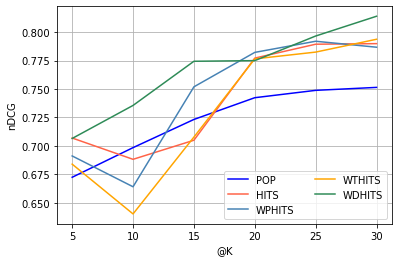

In [32]:
import numpy as np
import matplotlib.pyplot as plt


t = np.arange(5, 35, 5)

fig, ax = plt.subplots()
ax.plot(t, ndcg_pop, label='POP', color='blue')
ax.plot(t, ndcg_auth, label='HITS', color='tomato')
ax.plot(t, ndcg_wauth, label='WPHITS', color='steelblue')
ax.plot(t, ndcg_wtauth, label='WTHITS', color='orange')
ax.plot(t, ndcg_wdauth, label='WDHITS', color='seagreen')


ax.set(xlabel='@K', ylabel='nDCG',)
ax.grid()
ax.legend(loc='lower right', ncol=2)
# plt.savefig('rank_auth_melb.pdf')
plt.show()


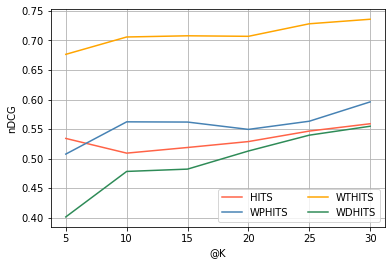

In [33]:
t = np.arange(5, 35, 5)

fig, ax = plt.subplots()
ax.plot(t, ndcg_hub, label='HITS', color='tomato')
ax.plot(t, ndcg_whub, label='WPHITS', color='steelblue')
ax.plot(t, ndcg_wthub, label='WTHITS', color='orange')
ax.plot(t, ndcg_wdhub, label='WDHITS', color='seagreen')


ax.set(xlabel='@K', ylabel='nDCG')
ax.grid()
ax.legend(loc='lower right', ncol=2)
# plt.savefig('rank_hub_melb.pdf')
plt.show()